# Проект: вариант 3

### Представьте, что вы работаете в крупном дейтинговом приложении.
Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

**Проверьте:**
Был ли эксперимент успешен в целом.

_*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит_

### Данные

**Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:**

users_*.csv – информация о пользователях:

- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки / просмотры * 1000)
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка

transactions_*.csv – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

### Файлы

- users_test – информация о пользователях в тестовой группе
- users_control_1 – информация о пользователях в первой контрольной группе
- users_control_2 – информация о пользователях во второй контрольной группе 
- transactions_test – информация о платежах пользователей в тестовой группе 
- transactions_control_1 – информация о платежах пользователей в первой контрольной группе
- transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

### План

1. **Сначала сделаем небольшой предварительный анализ:**
    - Посмотрим на данные и изучим их, внесем необходимые изменения
    - Отберем нужных пользователей (новых, из определенных стран и с определенными платежными системами оплаты)
    
    
2. **Общая оценка данных:**
    - Сравним группы для определения репрезентативности выборок
    - Построим графики
    
       
3. **A/A/B тесты:**
     - Выбираем гипотезы 
     - Выбираем подходящие статистические тесты
     - Тестируем
     
         
4. **Подводим итоги:**
    - Формулируем вывод 
    - Отвечаем на заданный вопрос: был ли эксперимент по изменению стоимости премиум-подписки в приложении успешен в целом

## 1: Предварительный анализ

**Загружаем данные**

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import datetime 

import scipy.stats as ss
from scipy.stats import chi2_contingency, f_oneway, kruskal, ttest_ind, mannwhitneyu
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("white")

In [2]:
# Скачиваем данные с Яндекс.Диска
def get_data(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    response = requests.get(base_url + 'public_key=' + public_key)
    download_response = requests.get(response.json()['href'])
    df = pd.read_csv(BytesIO(download_response.content), sep = ';')
    return df

In [3]:
# Читаем наши файлы
users_test             = get_data('https://disk.yandex.ru/d/4XXIME4osGrMRA')
users_control_1        = get_data('https://disk.yandex.ru/d/yJFydMNNGkEKfg')
users_control_2        = get_data('https://disk.yandex.ru/d/br6KkQupzzTGoQ')
transactions_test      = get_data('https://disk.yandex.ru/d/gvCWpZ55ODzs2g')
transactions_control_1 = get_data('https://disk.yandex.ru/d/VY5W0keMX5TZBQ')
transactions_control_2 = get_data('https://disk.yandex.ru/d/th5GL0mGOc-qzg')

**Посмотрим на наши df, изучим их тип данных и пропущенные значения, внесем необходимые изменения**

In [4]:
# Пользователи тестовой группы
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [5]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


Есть пропуски в колонках:
- coins (у пользователя нет внутренней валюты, т.е. она равно 0)
- visit_days (пользователь не посещал приложение после регистрации, т.е. 0 дней)
- was_premium (у пользователя не было премиум подписки, т.е. 0, т.к. наличие подписки обозначается как 1)
- is_premium (у пользователя на настоящий момент нет премиум подписки, т.е. 0)

In [6]:
# Обозначение гендера
users_test.gender.unique()

array([1, 0])

Можно предположить, что gender 1 - мужчина, 0 - женщина

In [7]:
# Число уникальных пользователей
users_test.uid.nunique()

4308

In [8]:
# Пользователи 1 контрольной группы
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [9]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [10]:
# Число уникальных пользователей
users_control_1.uid.nunique()

4340

In [11]:
# Пользователи 2 контрольной группы
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [12]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [13]:
# Число уникальных пользователей
users_control_2.uid.nunique()

4264

Проверим, уникальны ли пользователи в каждой группе, нет ли одних и тех же юзеров в разных выборках:

In [14]:
users_test.query('uid in @users_control_1.uid').shape[0]

0

In [15]:
users_test.query('uid in @users_control_2.uid').shape[0]

0

In [16]:
users_control_1.query('uid in @users_control_2.uid').shape[0]

0

Во всех df строки с уникальными пользователями. Но можем дополнительно проверить df на дубликаты:

In [17]:
users_test.duplicated().sum()

0

In [18]:
users_control_1.duplicated().sum()

0

In [19]:
users_control_2.duplicated().sum()

0

В контрольных группах пропуски в тех же колонках, что и в тестовой, все их можно заменить на нули, смысл от этого не изменится:

In [20]:
users_test      = users_test.fillna(0)
users_control_1 = users_control_1.fillna(0)
users_control_2 = users_control_2.fillna(0)

**Изучим датасеты с платежами пользователей**

In [21]:
# Платежи пользователей в тестовой группе
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [22]:
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


In [23]:
# Число уникальных uid в тестовой группе
transactions_test.uid.nunique()

146

In [24]:
# Платежи пользователей в 1 контрольной группе
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [25]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


In [26]:
# Число уникальных uid в 1 контрольной группе
transactions_control_1.uid.nunique()

193

In [27]:
# Платежи пользователей в 2 контрольной группе
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [28]:
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


In [29]:
# Число уникальных uid во 2 контрольной группе
transactions_control_2.uid.nunique()

187

Проверим уникальность юзеров в датасетах с транзакциями:

In [30]:
transactions_test.query('uid in @transactions_control_1.uid').shape[0]

0

In [31]:
transactions_test.query('uid in @transactions_control_2.uid').shape[0]

0

In [32]:
transactions_control_2.query('uid in @transactions_control_1.uid').shape[0]

0

Проверим данные на дубликаты и удалим их при наличии:

In [33]:
transactions_test.duplicated().sum()

7

In [34]:
transactions_control_1.duplicated().sum()

650

In [35]:
transactions_control_2.duplicated().sum()

5

In [36]:
transactions_test      = transactions_test.drop_duplicates()
transactions_control_1 = transactions_control_1.drop_duplicates()
transactions_control_2 = transactions_control_2.drop_duplicates()

В тестовой группе и 2 контрольной группе нет пропусков.
В 1 контрольной группе странная ситуация - количество строк значительно больше, чем в предыдущих датафреймах, но также много пропусков во всех колонках кроме joined_at и paid_at, предполагаем, что это сбой в системе и удаляем эти строки:

In [37]:
transactions_control_1 = transactions_control_1.dropna()

In [38]:
# Заменим в df transactions_control_1 тип данных на int у колонок с id для унификации
transactions_control_1[['uid', 'payment_id']] = transactions_control_1[['uid', 'payment_id']].astype(int)

In [39]:
# Исправим некорректный для дат тип данных в df по платежам
transactions_test[['joined_at', 'paid_at']]      = transactions_test[['joined_at', 'paid_at']].apply(pd.to_datetime)
transactions_control_1[['joined_at', 'paid_at']] = transactions_control_1[['joined_at', 'paid_at']].apply(pd.to_datetime)
transactions_control_2[['joined_at', 'paid_at']] = transactions_control_2[['joined_at', 'paid_at']].apply(pd.to_datetime)

**Отберем нужных нам пользователей (новых, из определенных стран и с определенными платежными системами оплаты)**

Новых пользователей найдем по датам регистрации, нужно чтобы они сходились во всех группах:

In [40]:
# Период проведения эксперимента в тестовой группе
transactions_test.joined_at.min(), transactions_test.joined_at.max()

(Timestamp('2017-01-11 03:07:00'), Timestamp('2017-10-31 23:40:00'))

In [41]:
# Период проведения эксперимента в 1 контрольной группе
transactions_control_1.joined_at.min(), transactions_control_1.joined_at.max()

(Timestamp('2015-01-19 11:49:00'), Timestamp('2017-10-31 22:17:00'))

In [42]:
# Период проведения эксперимента во 2 контрольной группе
transactions_control_2.joined_at.min(), transactions_control_2.joined_at.max()

(Timestamp('2017-01-11 08:36:00'), Timestamp('2017-10-31 17:43:00'))

Окончание эксперимента плюс минус совпадает у всех групп (не будем сверять всех по времени, даты достаточно).

А вот минимальная дата в 1 контрольной группе не совпадает с минимальными датами в других группах, отфильтруем лишнее:

In [43]:
transactions_control_1.query('joined_at < "2017-01-11"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0,refund_WP,other_type


In [44]:
# Уберем пользователя из обоих df
transactions_control_1 = transactions_control_1.query('uid != "960936960.0"')
users_control_1        = users_control_1.query('uid != "960936960"')

Отбираем нужные страны. Составим список стран, которые есть во всех датасетах users_* и transactions_* (т.к. изменения коснулись премиум пользователей). Будем считать, что именно в этих странах производился эксперимент.

In [45]:
country_ls = list(transactions_test \
                       .query('country in @transactions_control_1.country.unique() and country in @transactions_control_2.country.unique() and country in @users_control_1.country.unique() and country in @users_control_2.country.unique() and country in @users_test.country.unique()') \
                       .country.unique())

In [46]:
# Оставляем записи пользователей только из этих стран
users_test      = users_test.query('country in @country_ls')
users_control_1 = users_control_1.query('country in @country_ls')
users_control_2 = users_control_2.query('country in @country_ls')

transactions_test      = transactions_test.query('country in @country_ls')
transactions_control_1 = transactions_control_1.query('country in @country_ls')
transactions_control_2 = transactions_control_2.query('country in @country_ls')

Отбираем 2 нужные платежные системы. Ищем записи в датасетах transaction_*, где присутствует премиум подписка (premium_no_trial) (т.к. изменили именно стоимость премиум подписки)

In [47]:
transactions_test.query('product_type == "premium_no_trial"').payment_id.value_counts()

147    61
68     12
0       1
Name: payment_id, dtype: int64

In [48]:
transactions_control_1.query('product_type == "premium_no_trial"').payment_id.value_counts()

147    85
68     16
0       2
Name: payment_id, dtype: int64

In [49]:
transactions_control_2.query('product_type == "premium_no_trial"').payment_id.value_counts()

147    88
68     11
0       1
Name: payment_id, dtype: int64

Платежная система 0 имеет всего 4 записи суммарно, поэтому мы можем исключить эту систему, т.к. по условию у нас их должно быть всего 2 - это системы 147 и 68.

Отбираем транзакции с этими платежными системами:

In [50]:
transactions_test      = transactions_test.query('payment_id == 147 or payment_id == 68')
transactions_control_1 = transactions_control_1.query('payment_id == 147 or payment_id == 68')
transactions_control_2 = transactions_control_2.query('payment_id == 147 or payment_id == 68')

In [51]:
transactions_control_2.shape

(150, 8)

Среди юзеров также отберем только этих пользователей, чтобы соблюсти все условия эксперимента, т.к. изменения коснулись только платящих пользователей.

In [52]:
users_test      = users_test.query('uid in @transactions_test.uid.unique()')
users_control_1 = users_control_1.query('uid in @transactions_control_1.uid.unique()')
users_control_2 = users_control_2.query('uid in @transactions_control_2.uid.unique()')

Посмотрим на соотношение оставшихся пользователей

In [53]:
# Процент тестовой группы
users_test.shape[0]/(users_control_1.shape[0] + users_control_2.shape[0] + users_test.shape[0])*100

29.061784897025174

In [54]:
# Процент 1 контрольной группы
users_control_1.shape[0]/(users_control_1.shape[0] + users_control_2.shape[0] + users_test.shape[0])*100

37.52860411899314

In [55]:
# Процент 2 контрольной группы
users_control_2.shape[0]/(users_control_1.shape[0] + users_control_2.shape[0] + users_test.shape[0])*100

33.40961098398169

Для убеждения в равном разделении пользователей между группами добавим статистический анализ.

Используем критерий хи-квадрат с ожидаемыми и наблюдаемыми частотами:

- $H_0$: ожидаемые и наблюдаемые частоты данных статистически значимо не различаются в группах (p-value > 0.05)
- $H_1$: ожидаемые и наблюдаемые частоты данных статистически значимо различаются в группах

In [56]:
obs = [users_test.shape[0], users_control_1.shape[0], users_control_2.shape[0]]
obs_sum = sum(obs)
exp = [obs_sum/3, obs_sum/3,  obs_sum/3]

ss.chisquare(obs, f_exp=exp)

Power_divergenceResult(statistic=4.700228832951947, pvalue=0.09535825103631365)

p-value > 0.05, нулевую гипотезу не отклоняем, т.е. размеры итоговых выборок в контрольных и тестовой группы статистически значимо не различаются.

In [57]:
# Итоговые размеры датасетов
users_test.shape

(127, 13)

In [58]:
users_control_1.shape

(164, 13)

In [59]:
users_control_2.shape

(146, 13)

In [60]:
transactions_test.shape

(137, 8)

In [61]:
transactions_control_1.shape

(169, 8)

In [62]:
transactions_control_2.shape

(150, 8)

Можно заметить, что даже после фильтрации на итоговых выборках такого размера нормальность распределений не играет важной роли.

Таким образом, были отобраны необходимые новые пользователи (по одинаковой минимальной дате) из некоторых стран (общие страны из всех датасетов), которые воспользовались двумя платежными системами (147 и 68 - общие системы из всех групп с оплатой премиум подписки).

## 2: Общая оценка данных


Исследуем наши данные по некоторым имеющимся признакам, чтобы удостовериться в репрезентативности выборок для последующего проведения А/А/В тестов, а также сделать некоторые предварительные выводы.

In [63]:
# Создадим в датасетах колонки с названием группы
users_test['group']      = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'

transactions_test['group']      = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_1['group'] = 'control_2'

In [64]:
# Объединим датасеты для удобства
users_merged        = pd.concat([users_test, users_control_1, users_control_2])
transactions_merged = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

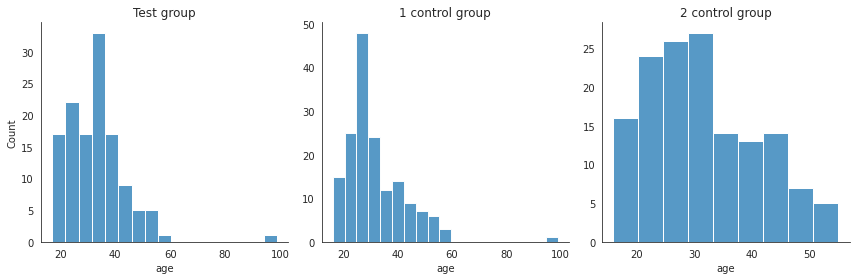

In [65]:
# Распределение пользователей в зависимости от возраста
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.histplot(x=users_test.age, ax = axes[0])
axes[0].set(title='Test group')

sns.histplot(x=users_control_1.age, ax = axes[1])
axes[1].set(title='1 control group', ylabel='')

sns.histplot(x=users_control_2.age, ax = axes[2])
axes[2].set(title='2 control group', ylabel='')

sns.despine()
plt.tight_layout()

In [66]:
# Посмотрим на средние значения возраста по группам
users_test.age.mean()

32.83464566929134

In [67]:
users_control_1.age.mean()

31.79268292682927

In [68]:
users_control_2.age.mean()

31.472602739726028

Проверим группы на гомоскедастичность:

- $H_0$: дисперсии равны, equal_var = True
- $H_1$: дисперсии различны

In [69]:
pg.homoscedasticity(data = users_merged, dv = 'age', group = 'group')

,W,pval,equal_var
levene,0.107369,0.898218,True


Тест на гомоскедастичность показал, что дисперсии в группах статистически не различны

Т.к. у нас 3 группы с количественными переменными, сравним их распределения при помощи критерия Краскела-Уоллиса:

- $H_0$: нет статистически значимых различий между распределениями возраста в тестовой и контрольных группах (p-value > 0.05)
- $H_1$: есть статистически значимые различия между распределениями возраста в тестовой и контрольных группах

In [70]:
kruskal(users_merged.query('group == "test"').age, users_merged.query('group == "control_1"').age, users_merged.query('group == "control_2"').age)

KruskalResult(statistic=1.8616835221800525, pvalue=0.39422173015390216)

Основная возрастная категория - молодежь (25-35 лет). Средний возраст пользователей - 32 года.

Согласно статистике (p-value > 0.05) нулевую гипотезу об отсутствии различий распределений возраста в тестовой и контрольных группах мы отклонить также не можем. Мы можем считать возрастное распределение в группах одинаковым, что говорит о репрезентативности выборок по этому признаку.

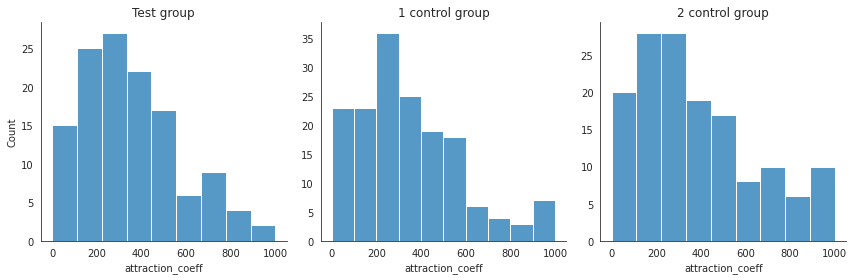

In [71]:
# Распределение пользователей в зависимости от коэффициента привлекательности
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.histplot(x=users_test.attraction_coeff, ax = axes[0])
axes[0].set(title='Test group')

sns.histplot(x=users_control_1.attraction_coeff, ax = axes[1])
axes[1].set(title='1 control group', ylabel='')

sns.histplot(x=users_control_2.attraction_coeff, ax = axes[2])
axes[2].set(title='2 control group', ylabel='')

sns.despine()
plt.tight_layout()

In [72]:
# Посмотрим на средние значения коэффициента привлекательности по группам
users_test.attraction_coeff.mean()

353.13385826771656

In [73]:
users_control_1.attraction_coeff.mean()

339.6219512195122

In [74]:
users_control_2.attraction_coeff.mean()

381.7260273972603

In [75]:
# Проверка на гомоскедастичность
pg.homoscedasticity(data = users_merged, dv = 'attraction_coeff', group = 'group')

,W,pval,equal_var
levene,2.508938,0.082534,True


Т.к. у нас 3 группы с количественными переменными, сравним их распределения при помощи критерия Краскела-Уоллиса:

- $H_0$: нет статистически значимых различий между распределениями коэффициента привлекательности в тестовой и контрольных группах (p-value > 0.05)
- $H_1$: есть статистически значимые различия между распределениями коэффициента привлекательности в тестовой и контрольных группах

In [76]:
kruskal(users_merged.query('group == "test"').attraction_coeff, users_merged.query('group == "control_1"').attraction_coeff, users_merged.query('group == "control_2"').attraction_coeff)

KruskalResult(statistic=1.3258233628683038, pvalue=0.5153486168360484)

Средний коэффициент привлекательности пользователей в группах - 340-382 (max - 1000)

Согласно статистике (p-value > 0.05) нулевую гипотезу об отсутствии различий распределений коэффициента привлекательности в тестовой и контрольных группах мы отклонить не можем. Т.е. мы можем считать распределения в группах одинаковыми, что говорит о репрезентативности выборок по этому признаку.

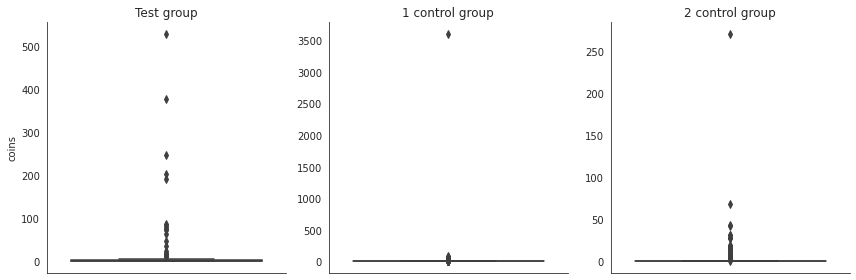

In [77]:
# Распределение пользователей в зависимости от количества внутренней валюты (coins)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.boxplot(y=users_test.coins, ax = axes[0])
axes[0].set(title='Test group')

sns.boxplot(y=users_control_1.coins, ax = axes[1])
axes[1].set(title='1 control group', ylabel='')

sns.boxplot(y=users_control_2.coins, ax = axes[2])
axes[2].set(title='2 control group', ylabel='')

sns.despine()
plt.tight_layout()

Проверим наш экстремальный выброс в 1 контрольной группе:

In [78]:
users_control_1.query('coins == coins.max()')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,control_1


In [79]:
transactions_control_1.query('uid == 892333905')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
143,892333905,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147,no_sympathy,premium_no_trial,control_2


Примем решение не удалять данного пользователя, он не должен испортить результат нашего анализа

In [80]:
# Проверка на гомоскедастичность
pg.homoscedasticity(data = users_merged, dv = 'coins', group = 'group')

,W,pval,equal_var
levene,0.547366,0.57887,True


Т.к. у нас 3 группы с количественными переменными, сравним их распределения при помощи критерия Краскела-Уоллиса:

- $H_0$: нет статистически значимых различий между распределениями количества внутренней валюты в тестовой и контрольных группах (p-value > 0.05)
- $H_1$: есть статистически значимые различия между распределениями количества внутренней валюты в тестовой и контрольных группах

In [81]:
kruskal(users_merged.query('group == "test"').coins, users_merged.query('group == "control_1"').coins, users_merged.query('group == "control_2"').coins)

KruskalResult(statistic=1.2617925744049447, pvalue=0.5321146596513002)

Наше p-value > 0.05, мы не можем отвергнуть нулевую гипотезу, т.е. различий между распределениями количества внутренней валюты пользователей разных групп нет, что говорит о репрезентативности выборок по данному признаку.

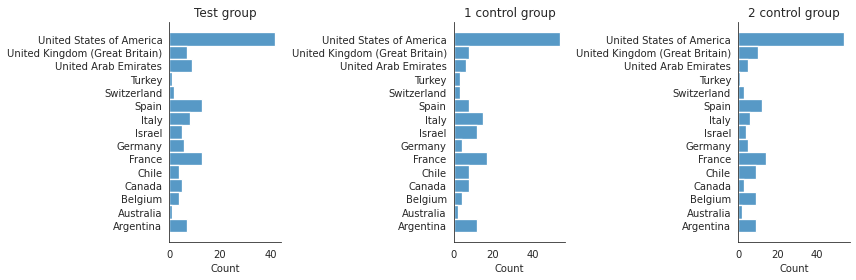

In [82]:
# Распределение пользователей в зависимости от страны 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.histplot(y=users_test.country.sort_values(ascending=False), ax = axes[0])
axes[0].set(title='Test group', ylabel='')

sns.histplot(y=users_control_1.country.sort_values(ascending=False), ax = axes[1])
axes[1].set(title='1 control group', ylabel='')

sns.histplot(y=users_control_2.country.sort_values(ascending=False), ax = axes[2])
axes[2].set(title='2 control group', ylabel='')

sns.despine()
plt.tight_layout()

Сравним наши распределения с помощью статистического теста.

Есть категориальные переменные (страна, группа пользователя) → нужен хи-квадрат

- $H_0$: нет статистически значимой разницы между распределениями пользователей по странам в тестовой и контрольных группах (p-value > 0.05)
- $H_1$: есть статистически значимая разница между распределениями пользователей по странам в тестовой и контрольных группах

In [83]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_merged.country, users_merged.group))
stat, p

(21.86910075724715, 0.7873150709907116)

Распределение пользователей в зависимости от страны согласно графикам примерно одинаково в тестовой и контрольных группах. Превалируют пользователи из США.

Согласно статистическому тесту (p-value > 0.05) мы не смогли отклонить нулевую гипотезу, не обнаружена статистически значимая разница между распределениями пользователей по странам в тестовой и контрольных группах, что говорит о репрезентативности выборок по этому признаку.

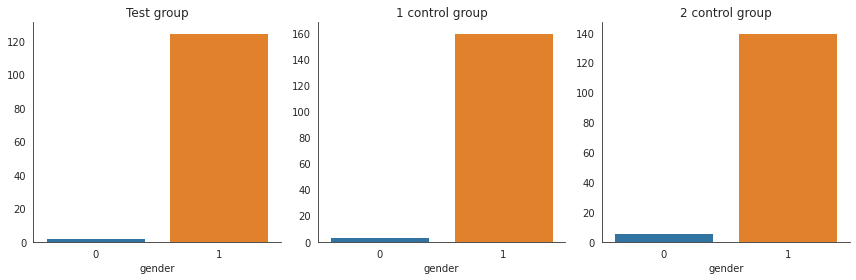

In [84]:
# Распределение пользователей в зависимости от пола
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.countplot(data=users_test, x = 'gender', ax = axes[0])
axes[0].set(title='Test group', ylabel='')

sns.countplot(data=users_control_1, x = 'gender', ax = axes[1])
axes[1].set(title='1 control group', ylabel='')

sns.countplot(data=users_control_2, x = 'gender', ax = axes[2])
axes[2].set(title='2 control group', ylabel='')

sns.despine()
plt.tight_layout()

Кажется, ранее было верно предположено, что 1 - это мужчины, а 0 - женщины, т.к. в дейтинг приложениях согласно статистике превалирует мужской пол.
Распределение пользователей во всех группах примерно одинаковое.

Также сравним наши распределения с помощью статистического теста.

Есть категориальные переменные (пол, группа пользователя) → нужен хи-квадрат

- $H_0$: нет статистически значимой разницы между распределениями пользователей по половому признаку в тестовой и контрольных группах (p-value > 0.05)
- $H_1$: есть статистически значимая разница между распределениями пользователей по половому признаку в тестовой и контрольных группах

In [85]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_merged.gender, users_merged.group))
stat, p

(1.72669415296182, 0.4217480941477504)

Согласно статистическому тесту (p-value > 0.05) также не обнаружена статистически значимая разница между распределениями пользователей по половому признаку в тестовой и контрольных группах, что говорит о репрезентативности выборок по этому признаку.

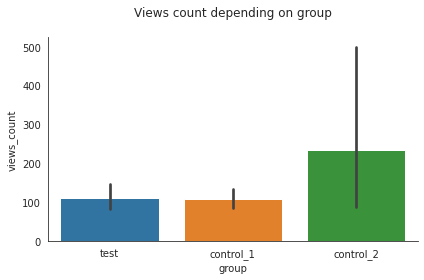

In [86]:
# Посмотрим на число оценок пользователей в зависимости от группы
sns.barplot(data = users_merged, x = 'group', y = 'views_count')
sns.despine()
plt.title('Views count depending on group\n')
plt.tight_layout()

In [87]:
# Тест на гомоскедастичность
pg.homoscedasticity(data = users_merged, dv = 'views_count', group = 'group')

,W,pval,equal_var
levene,1.271269,0.281518,True


Т.к. у нас 3 группы, сравним их распределения при помощи критерия Краскела-Уоллиса:

- $H_0$: нет статистически значимых различий между распределениями количества просмотров в тестовой и контрольных группах (p-value > 0.05)
- $H_1$: есть статистически значимые различия между распределениями количества просмотров в тестовой и контрольных группах

In [88]:
kruskal(users_merged.query('group == "test"').views_count, users_merged.query('group == "control_1"').views_count, users_merged.query('group == "control_2"').views_count)

KruskalResult(statistic=1.9364385074056973, pvalue=0.37975869022377584)

Наше p-value > 0.05, мы не можем отвергнуть нулевую гипотезу, т.е. статистически значимых различий между распределениями количества просмотров пользователей разных групп нет, по данному признаку выборки репрезентативны.

Итак, в ходе проверки наших выборок по нескольких признакам, мы удостоверились в их репрезентативности, имеем качественное разделение пользователей по группам.

## 3: Проводим А/А/В тесты. Тестируем гипотезы

Для оценки успешности эксперимента по изменению стоимости премиум-подписки будем полагаться в первую очередь на изменение **ARPPU_pr (средний доход на платящего премиум пользователя)**, т.к. эксперимент направлен на премиум пользователей, и доход от них - важный для бизнеса показатель. 

- $H_0$: ARPPU_pr в тестовой группе статистически значимо больше, чем в контрольных группах
- $H_1$: ARPPU_pr в тестовой группе статистически значимо меньше, чем в контрольных группах, либо статистически значимо не изменился

Но также обратим внимание на такие экономические метрики как:

- CR_pr (конверсия из пользователя в покупателя премиум подписки, т.к. в наших итоговых выборках уже все пользователи = покупатели)
- ARPPU (средний доход на платящего пользователя, без премиум подписки)
(т.к. в наших выборках все пользователи - платящие, будем рассчитывать ARPPU и ARPPU_pr как доход на платящего пользователя и доход на платящего именно за премиум подписку пользователя соответственно)

Эти метрики непосредственно связаны с метрикой ARPPU_pr, и при внесении изменений нельзя не обращать на них внимание.

И посмотрим на такие метрики как:
- соотношение пользователей, продливших/не продливших премиум подписку

Пользователи могут менее охотно продлевать премиум подписку, если ее стоимость будет слишком высокая (или более охотно, если низкая), т.е. изменится число премиум пользователей и впоследствии может измениться доход от них.

- количество дней посещения (visit days) 

Есть предположение, что есть взаимосвязь между стоимостью подписки и количеством посещений приложения (можно сравнить это с абонементом в спорт зал - чем выше его стоимость, тем больше мотивация его посещать). То есть заплатив весомую сумму, клиент захочет, чтобы эта трата была оправдана, и будет чаще посещать приложение. А большая возвращаемость клиента может способствовать увеличению дохода от него.

Эти метрики хоть и опосредовано, но все же влияют на основую метрику ARPPU_pr, и могут внести вклад в успех эксперимента.

Проведем **А/А тест для контрольных групп** перед А/В тестированием.

Для начала проверим группы на гомоскедастичность:

In [89]:
pg.homoscedasticity(data = users_merged.query('total_revenue > 0 and group != "test"'), dv = 'total_revenue', group = 'group')

,W,pval,equal_var
levene,0.737499,0.391133,True


Будем использовать t-тест, который сравнивает средние значения ARPPU двух выборок:

- $H_0$: нет статистически значимых различий между средними значениями ARPPU в контрольных группах
- $H_1$: есть статистически значимые различия между средними значениями ARPPU в контрольных группах

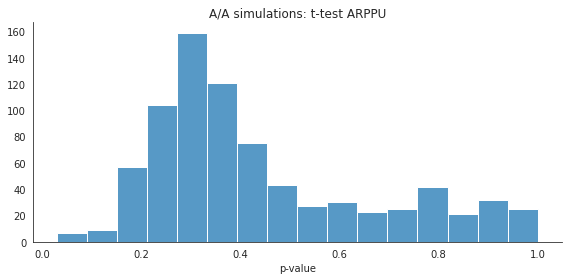

In [90]:
df = []

for i in range(800):
    c_1 = users_control_1.query('total_revenue > 0').total_revenue.sample(100, replace = False).values
    c_2 = users_control_2.query('total_revenue > 0').total_revenue.sample(100, replace = False).values
    df.append(ttest_ind(c_1, c_2, equal_var = False)[1])

fig, axes = plt.subplots(figsize=(8, 4))
sns.histplot(df)
axes.set(title = 'A/A simulations: t-test ARPPU', xlabel = 'p-value', ylabel = '')
sns.despine()
plt.tight_layout()

In [91]:
# Проверим, что количество ложноположительных случаев не превышает уровень значимости (0.05)
((np.array(df) < 0.05) / 800).sum() <= 0.05

True

Нулевую гипотезу мы не можем отвергнуть, т.е. статистически значимых различий по ARPPU в контрольных группах не наблюдается.

Таким образом, в А/В тестах мы может использовать только одну из контольных групп, предпочтем группу "control_2", т.к. эта выборка претерпевала меньше изменений в предобработке, чем группа "control_1"

In [92]:
# Соберем информацию по пользователям, продливших / не продливших подписку
users_premium = users_merged[['uid', 'was_premium', 'is_premium', 'group']].query('group != "control_1"')
users_premium.head()

,uid,was_premium,is_premium,group
20,891152790,1.0,1.0,test
44,891589239,1.0,1.0,test
100,891343671,1.0,1.0,test
105,892430988,1.0,1.0,test
134,891919368,1.0,1.0,test


In [93]:
users_premium.query('was_premium == 0.0 and is_premium == 1.0').shape[0]

0

Пользователей, у которых не было подписки, и она появилась, нет (что логично), поэтому у нас будет разделение на 3 группы:

In [94]:
def f(row):
    if row['was_premium'] == 0.0 and row['is_premium'] == 0.0:
        x = 'no'
    elif row['was_premium'] == 1.0 and row['is_premium'] == 0.0:
        x = 'canceled'
    else:
        x = 'not canceled'
    return x

users_premium['premium'] = users_premium.apply(f, axis = 1)
users_premium.head()

,uid,was_premium,is_premium,group,premium
20,891152790,1.0,1.0,test,not canceled
44,891589239,1.0,1.0,test,not canceled
100,891343671,1.0,1.0,test,not canceled
105,892430988,1.0,1.0,test,not canceled
134,891919368,1.0,1.0,test,not canceled


In [95]:
users_premium.groupby(['group', 'premium']).size()

group      premium     
control_2  canceled         10
           not canceled    136
test       canceled          7
           not canceled    120
dtype: int64

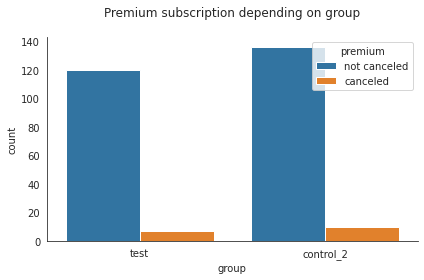

In [96]:
# Визуацизация распределений
sns.countplot(data=users_premium, x = 'group', hue = 'premium')

sns.despine()
plt.title('Premium subscription depending on group\n')
plt.tight_layout()

Визуально различия не велики. Проверим данные статистикой:
Есть категориальные переменные (категория в зависимости от подписки, группа пользователя) → нужен хи-квадрат

- $H_0$: нет статистически значимой разницы между распределениями пользователей в зависимости от подписки (продлили/ не продлили) в тестовой и контрольной группе (p-value > 0.05)
- $H_1$: есть статистически значимая разница между распределениями пользователей в зависимости от подписки (продлили/ не продлили) в тестовой и контрольной группе


In [97]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_premium.premium, users_premium.group))
stat, p

(0.04205977241354288, 0.8375058771665312)

In [98]:
# Посмотрим статистику еще через пингвин
exp, obs, stats = pg.chi2_independence(data=users_premium, 
                                       x='group', 
                                       y='premium') 
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.042060,1.0,0.837506,0.012412,0.054832
1,cressie-read,0.666667,0.042093,1.0,0.837443,0.012417,0.054836
2,log-likelihood,0.000000,0.042163,1.0,0.837309,0.012428,0.054844
3,freeman-tukey,-0.500000,0.042221,1.0,0.837199,0.012436,0.054851
4,mod-log-likelihood,-1.000000,0.042283,1.0,0.837081,0.012445,0.054858
5,neyman,-2.000000,0.042418,1.0,0.836824,0.012465,0.054873


Согласно статистике (p-value > 0.05) нулевую гипотезу об отсутствии разницы между распределениями пользователей в зависимости от подписки (продлили/ не продлили) в тестовой и контрольной группе мы отклонить не можем.

In [99]:
# Сравним количество дней посещения пользователей в зависимости от группы (visit days)

# Преобразуем колонку с номерами дней в нужный формат
users_merged['visit_days'] = users_merged['visit_days'].str.split(',\s*')

In [100]:
# Добавим колонку с количеством дней посещения
users_merged['days_count'] = users_merged.visit_days.str.len()

In [101]:
# Изменим NaN на нули и поменяем тип данных на int
users_merged['days_count'] = users_merged['days_count'].fillna(0).astype(int)

In [102]:
# Среднее количество дней посещения
users_merged.groupby('group', as_index = False).agg({'days_count' : 'mean'})

,group,days_count
0,control_1,9.707317
1,control_2,9.287671
2,test,9.244094


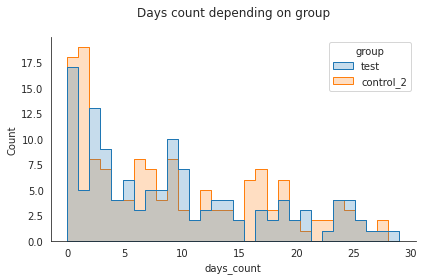

In [103]:
# Визуализация
sns.histplot(data = users_merged.query('group != "control_1"'), hue = 'group', x = 'days_count', bins = 30, element='step')
sns.despine()
plt.title('Days count depending on group\n')
plt.tight_layout()

Визуально сильные различия не наблюдаются. Посмотрим статистику

In [104]:
# Тест на гомоскедастичность (equal_var = True)
pg.homoscedasticity(data = users_merged, dv = 'days_count', group = 'group')

,W,pval,equal_var
levene,0.156987,0.854764,True


Т.к. у нас 2 группы, сравним их распределения при помощи критерия Манна-Уитни:

- $H_0$: нет статистически значимых различий между распределениями количества посещений в тестовой и контрольной группе (p-value > 0.05)
- $H_1$: есть статистически значимые различия между распределениями количества посещений в тестовой и контрольной группе

In [105]:
mannwhitneyu(users_merged.query('group == "test"').days_count, users_merged.query('group == "control_2"').days_count)

MannwhitneyuResult(statistic=9358.0, pvalue=0.8940167190188826)

Наше p-value > 0.05, мы не можем отвергнуть нулевую гипотезу, т.е. статистически значимых различий между распределениями количества посещений в тестовой и контрольной группе нет, пользователи не стали чаще или реже заходить в приложение в связи с изменением стоимости премиум-подписки.

**Рассчитаем метрики экономики для тестовой и контрольной группы и создадим сводную таблицу:**

In [106]:
metrics = []

users = users_test.uid.nunique()
premium_users = transactions_test.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique()
revenue = transactions_test.revenue.sum()
CR_pr = (premium_users/users)
ARPPU = (revenue/users)
ARPPU_pr = (revenue/premium_users)

metrics.append(pd.DataFrame(index = ['test'], data = {'users':users, 'premium_users':premium_users, 
                                                      'CR_pr':CR_pr, 'ARPPU':ARPPU, 'ARPPU_pr':ARPPU_pr}))
metrics = pd.concat(metrics)
metrics

,users,premium_users,CR_pr,ARPPU,ARPPU_pr
test,127,65,0.511811,12868.259843,25142.6


In [107]:
metrics_1 = []

users = users_control_2.uid.nunique()
premium_users = transactions_control_2.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique()
revenue = transactions_control_2.revenue.sum()
CR_pr = (premium_users/users)
ARPPU = (revenue/users)
ARPPU_pr = (revenue/premium_users)

metrics_1.append(pd.DataFrame(index = ['control_2'], data = {'users':users, 'premium_users':premium_users,
                                                      'CR_pr':CR_pr, 'ARPPU':ARPPU, 'ARPPU_pr':ARPPU_pr}))

metrics_1 = pd.concat(metrics_1)
metrics_1

,users,premium_users,CR_pr,ARPPU,ARPPU_pr
control_2,146,95,0.650685,9038.650685,13890.978947


In [108]:
metrics_merged = pd.concat([metrics, metrics_1])

# Округлим значения
metrics_merged[['CR_pr']] = metrics_merged[['CR_pr']].round(4)
metrics_merged[['ARPPU', 'ARPPU_pr']] = metrics_merged[['ARPPU', 'ARPPU_pr']].round(2)
metrics_merged

,users,premium_users,CR_pr,ARPPU,ARPPU_pr
test,127,65,0.5118,12868.26,25142.60
control_2,146,95,0.6507,9038.65,13890.98


In [109]:
# Выделим максимальные и минимальные значения метрик цветом
(metrics_merged
 .style
 .format('{:.4f}', subset = ['CR_pr'])
 .format('{:.2f}', subset = ['ARPPU', 'ARPPU_pr'])
 .highlight_max(color='yellowgreen', subset = ['CR_pr', 'ARPPU', 'ARPPU_pr'])
 .highlight_min(color='coral', subset = ['CR_pr', 'ARPPU', 'ARPPU_pr'])
)

,users,premium_users,CR_pr,ARPPU,ARPPU_pr
test,127,65,0.5118,12868.26,25142.60
control_2,146,95,0.6507,9038.65,13890.98


По результатам вычислений метрик экономики можно сделать следующие выводы:

В тестовой группе по сравнению с контрольной уменьшилась метрика CR_pr (конверсия в покупку премиум подписки) на 21%. Т.е. в ходе эксперимента покупать премиум подписку стали реже, видимо стоимость подписки изменилась в большую сторону.

В тестовой группе по сравнению с контрольными увеличились метрики: 
- средний доход на платящего пользователя (+42%)
- средний доход на платящего премиум пользователя (+82%)

Т.е. хоть количество платящих пользователей уменьшилось, но их "качество" - доход от них - значительно увеличился. Пользователи стали покупать на большую сумму (потдверждение того, что стоимость премиум подписки увеличилась).


Выручка выросла, но она включает выручку от всех продуктов (пробная премиум-подписка, премиум-подписка, другой тип), тогда как цена менялась только на один (премиум-подписка). 

Посмотрим, как этот эффект роста среднего распределён по видам продуктов, за счёт какого продукта в итоге стали больше зарабатывать.

In [110]:
ARPPU_product_type = transactions_merged.groupby(['group', 'product_type'], as_index = False).agg({'revenue' : 'sum', 'uid' : 'nunique'})
ARPPU_product_type['ARPPU'] = ARPPU_product_type.revenue / ARPPU_product_type.uid

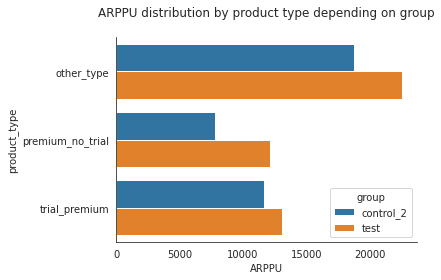

In [111]:
sns.barplot(data=ARPPU_product_type, y='product_type', x='ARPPU', hue='group')
sns.despine()
plt.title('ARPPU distribution by product type depending on group\n')
plt.tight_layout()

По графику можем видеть, что ни по одному виду product_type наша выручка не просела, везде идет ее рост в тестовой группе по сравнению с контрольной. 

Причем для премиум подписки идет самый большой рост, пользователи не начали в большей степени переходить на другие платные опции.

Сравним конверсию из пользователя в покупателя премиум подписки (CR_pr) в группах.
Т.к. переменные номинативные - используем хи-квадрат:

- $H_0$: нет статистически значимой разницы между распределением CR_pr в тестовой и контрольной группе (p-value > 0.05)
- $H_1$: есть статистически значимая разница между распределением CR_pr в тестовой и контрольной группе

In [489]:
# Добавим в данные колонку с конверсией в покупателя премиум подписки в зависимости от типа подписки (product_type)
users_merged['CR_pr'] = users_merged.uid.isin(transactions_merged.query('product_type == "premium_no_trial"').uid.unique()).astype(int)

In [490]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_merged.query('group != "control_1"').CR_pr, users_merged.query('group != "control_1"').group))
stat, p

(4.842316410131557, 0.02776956942901534)

Так как p < 0.05, мы отвергаем нулевую гипотезу, т.е. есть статистически значимая разница в распределении CR_pr в тестовой и контрольной группе, конверсия в покупателя премиум подписки уменьшилась.

Сравним средний доход на платящего пользователя (ARPPU) в группах при помощи статистического F теста:

- $H_0$: нет статистически значимых различий между средними значениями ARPPU в тестовой и контрольной группе (p-value > 0.05)
- $H_1$: есть статистически значимые различия между средними значениями ARPPU в тестовой и контрольной группе

Проверим группы на гомоскедастичность:

In [491]:
pg.homoscedasticity(data = users_merged, dv = 'total_revenue', group = 'group')

,W,pval,equal_var
levene,0.543017,0.581387,True


In [492]:
stat, p_value = f_oneway(users_test.total_revenue, users_control_2.total_revenue)
print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

F Test: statistic=10.4186, p-value=0.0014


Согласно статистике F-теста (p-value < 0.05) нулевую гипотезу об отсутствии различий между средними значениями ARPPU в тестовой и контрольной группе мы отклоняем, т.е. различия статистически не значимы, значение ARPPU увеличилось.

Сравним средний доход на платящего премиум пользователя (ARPPU_pr) в группах при помощи статистического F теста:

- $H_0$: нет статистически значимых различий между средними значениями ARPPU_pr в тестовой и контрольной группе (p-value > 0.05)
- $H_1$: есть статистически значимые различия между средними значениями ARPPU_pr в тестовой и контрольной группе

Проверим группы на гомоскедастичность:

In [493]:
pg.homoscedasticity(data = users_merged.query('total_revenue > 0'), dv = 'total_revenue', group = 'group')

,W,pval,equal_var
levene,0.538057,0.584272,True


In [494]:
stat, p_value = f_oneway(users_test.query('total_revenue > 0').total_revenue, 
                         users_control_2.query('total_revenue > 0').total_revenue)
print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

F Test: statistic=10.4186, p-value=0.0014


p < 0.05, мы отвергаем нулевую гипотезу и делаем вывод, что ARPPU_pr в тестовой группе статистически значимо больше ARPPU_pr в контрольной группе. 

## 4: Подводим итоги
Из предоставленных датасетов были отобраны только новые пользователи из нескольких стран, в которых была изменена стоимость премиум-подписки при покупке через две новые платежные системы.

**По итоговым выборкам можно сказать следующее:**
- Выборки для анализа репрезентативные, группы пользователей распределены одинаково по приведенным признакам, но были произведены некоторые манипуляции по удалению неподходящих данных и выбросов (в особенности в 1 контрольной группе, поэтому в А/В тестах использовалась 2 контрольная группа)
- Основная возрастная категория - молодежь (25-35 лет). Средний возраст пользователей - 32 года
- Средний коэффициент привлекательности пользователей - 340-382 (max - 1000)
- По географическому признаку превалируют пользователи из США
- По половому признаку превалируют мужчины

**Согласно проведенным исследованиям:**
- Статистически значимо не изменилось количество дней посещения приложения
- Статистически значимо не изменилось количество пользователей, продливших премиум подписку

- Конверсия в покупку премиум подписки (CR_pr) уменьшилась на 21% (стат значимо). Т.е. в ходе эксперимента покупать стали реже, видимо стоимость подписки изменилась в большую сторону, и часть пользователей отказалась от платных услуг

- Средний доход на платящего пользователя (ARPPU) увеличился на 42% (стат значимо) (причем доход увеличился по всем видам продукта)
- Средний доход на платящего за премиум подписку пользователя (ARPPU_pr) увеличился на 82% (стат значимо). Т.е. хоть количество платящих пользователей уменьшилось, но их "качество" - доход от них - значимо увеличился. Платящие пользователи стали покупать на большую сумму (что логично при увеличении стоимости премиум подписки)


Таким образом, судя по нашей основной метрике - ARPPU_pr - эксперимент оказался удачным, изменение (предполагаемо повышение) стоимости премиум подписки при оплате через 2 новые платежные системы статистически значимо увеличило метрику ARPPU_pr.

Но есть опасение, что в долгосрочной перспективе падениеCR_pr может привести к большим потерям платящих за премиум подписку пользователей, и ARPPU_pr не сможет нивелировать эти потери. 

Рекомендуется раскатывать данное обновление, но также необходимо периодически мониторить данные экономические показатели.